# Hierarchical Star - Spectroscopic Observables

This notebook shows how you can use the `MultieStarModel` to infer stellar parameters with spectroscopic observables effective temperature, surface gravity, and metallicity (`Teff`, `log_g`, `M_H`).

Firstly, import packages.

In [1]:
import numpy as np
import numpyro
import arviz as az
import matplotlib.pyplot as plt

from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value
from numpyro.infer.reparam import LocScaleReparam
from time import time
# numpyro.set_host_device_count(10)
# numpyro.enable_x64()
numpyro.set_host_device_count(2)

Then, import the `HierarchicalStarModel` from `celestify`.

In [2]:
from celestify.numpyro_models import HierarchicalStarModel

2023-12-13 17:19:16.411455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 17:19:16.411489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 17:19:16.412556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 17:19:16.985841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [3]:
# hyperparam_names = ["mu_Y", "mu_a", "sigma_Y", "sigma_a"]
hyperparam_names = ["dY_dZ", "sigma_Y", "da_dM", "sigma_a"]
# hyperparam_names = ["dY_dZ", "sigma_Y", "mu_a", "sigma_a"]

In [68]:
rng = random.PRNGKey(0)  # create random key to use throughout notebook
num_stars = 100

rng, key = random.split(rng)
true_model = HierarchicalStarModel(num_stars)
truths = {
    # "mu_Y": 0.27,
    "dY_dZ": 1.5,
    "sigma_Y": 0.005,
    # "mu_a": 2.0,
    "da_dM": -0.3,
    "sigma_a": 0.05,
}
# This samples from the true model given some random key
true_trace = handlers.trace(
    handlers.seed(handlers.substitute(true_model, truths), key)
).get_trace()
truths.update({key: param["value"] for key, param in true_trace.items()})
pprint(truths)

{'M_H': Array([ 0.06628172,  0.12074792,  0.11131931, -0.6035274 , -0.6388973 ,
       -0.11964085,  0.00817403, -0.28605813, -0.37928098, -0.31270656,
       -0.33071303, -0.0356029 , -0.08424841, -0.525579  , -0.39855897,
       -0.8676966 , -0.3158085 , -0.6498934 ,  0.35184935, -0.08199926,
       -0.37392882, -0.08644041,  0.33033228, -0.6517191 , -0.8533362 ,
       -0.2131817 , -0.23477653, -0.35985154, -0.02323987, -0.07223558,
       -0.02783745,  0.14226566,  0.03230282, -0.56952786, -0.41339412,
       -0.10458584,  0.21984921,  0.22237712, -0.7371682 ,  0.3324534 ,
       -0.36910588,  0.14460635, -0.47069135, -0.43598837,  0.25329238,
       -0.87966096, -0.28070712, -0.3509488 , -0.1878146 ,  0.07191141,
       -0.4955651 , -0.0882499 , -0.48642468, -0.03060291, -0.5453774 ,
       -0.87187123, -0.6538266 ,  0.25412276, -0.5353631 , -0.11748955,
        0.28756362, -0.45143384, -0.01415276,  0.3926605 ,  0.01013794,
        0.3447503 , -0.28079858, -0.7754476 , -0.0879865

## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [69]:
rng, key = random.split(rng)

sigma_mh = 0.1
mu_mh = truths["M_H"] + sigma_mh * random.normal(key, shape=truths["M_H"].shape)  # add noise to metallicity prior

# Create dictionary of model constants
const = {
    "M_H": dict(loc=mu_mh, scale=sigma_mh),
    "Teff": dict(scale=75.),
    # "log_g": dict(scale=0.1),
    "log_L": dict(scale=0.015)
}

# Create model
model = HierarchicalStarModel(num_stars, const=const)

pprint(model.const)  # check all constants

{'M_H': {'loc': Array([ 2.66118199e-01,  3.18710580e-02,  1.43712193e-01, -4.49545920e-01,
       -6.51017785e-01, -3.48213524e-01, -9.74796265e-02, -2.72926599e-01,
       -2.89132923e-01, -2.63889372e-01, -3.56651485e-01, -3.34180892e-04,
       -2.09708974e-01, -7.20220149e-01, -3.70908350e-01, -9.57566738e-01,
       -2.10207433e-01, -6.73197567e-01,  3.90556574e-01, -5.89918047e-02,
       -4.10331547e-01,  5.10665998e-02,  4.14919466e-01, -6.29533231e-01,
       -8.61180961e-01, -2.63571888e-01, -2.74639189e-01, -2.24157989e-01,
       -1.20363899e-01, -1.11695215e-01,  6.80686161e-02,  3.26298982e-01,
        1.61426496e-02, -6.58606350e-01, -4.63208646e-01, -1.53850004e-01,
        2.77383745e-01,  7.14701265e-02, -5.69863677e-01,  3.09220552e-01,
       -3.77498746e-01, -1.98771805e-02, -5.00937581e-01, -5.05987465e-01,
        4.16725874e-01, -9.27165210e-01, -3.31331849e-01, -2.87181854e-01,
       -9.64952707e-02, -6.76050335e-02, -5.51231623e-01, -2.50559539e-01,
       -6

## Prior Predictive

Sample from the model prior.

In [70]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=1000)
prior_samples = prior_predictive(key)

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [71]:
coords = {"star": np.arange(num_stars)}
# coords = {"star": good_stars}
dims = {key: ["star"] for key, value in prior_samples.items() if value.ndim > 1}
data = az.from_numpyro(prior=prior_samples, coords=coords, dims=dims)
data

Inference data with groups:
	> prior

We can plot the prior and overlay the true values with the `corner` package.

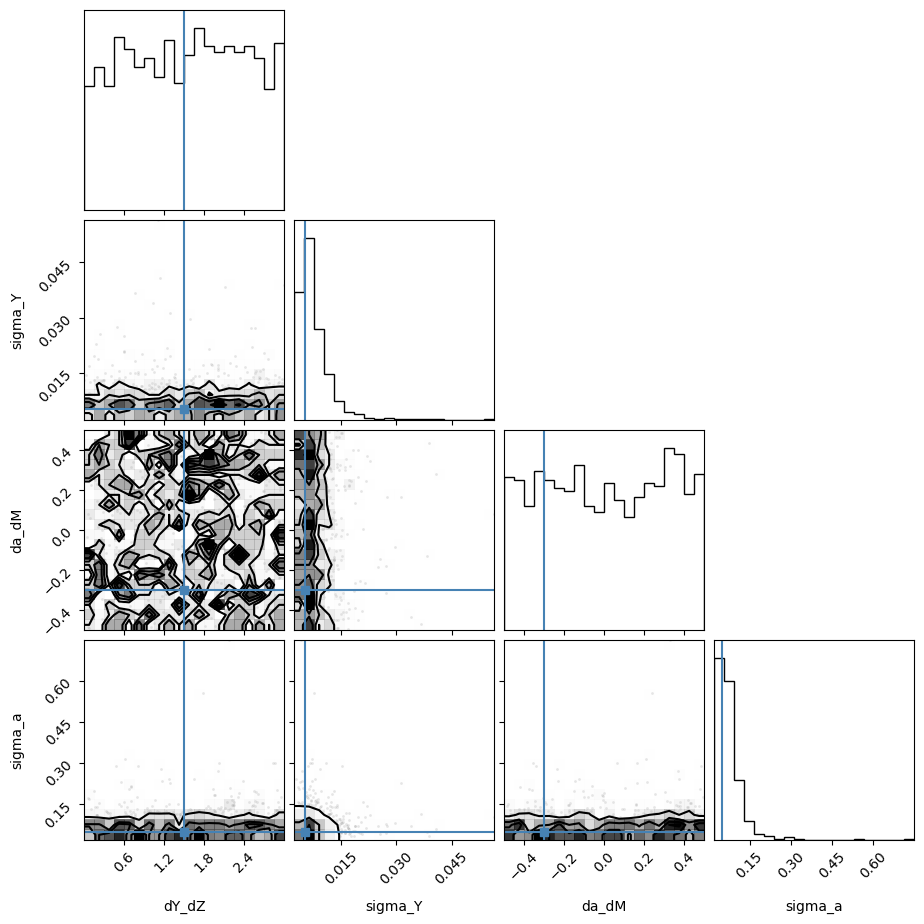

In [72]:
fig = corner(data, group="prior", var_names=hyperparam_names, truths=truths)

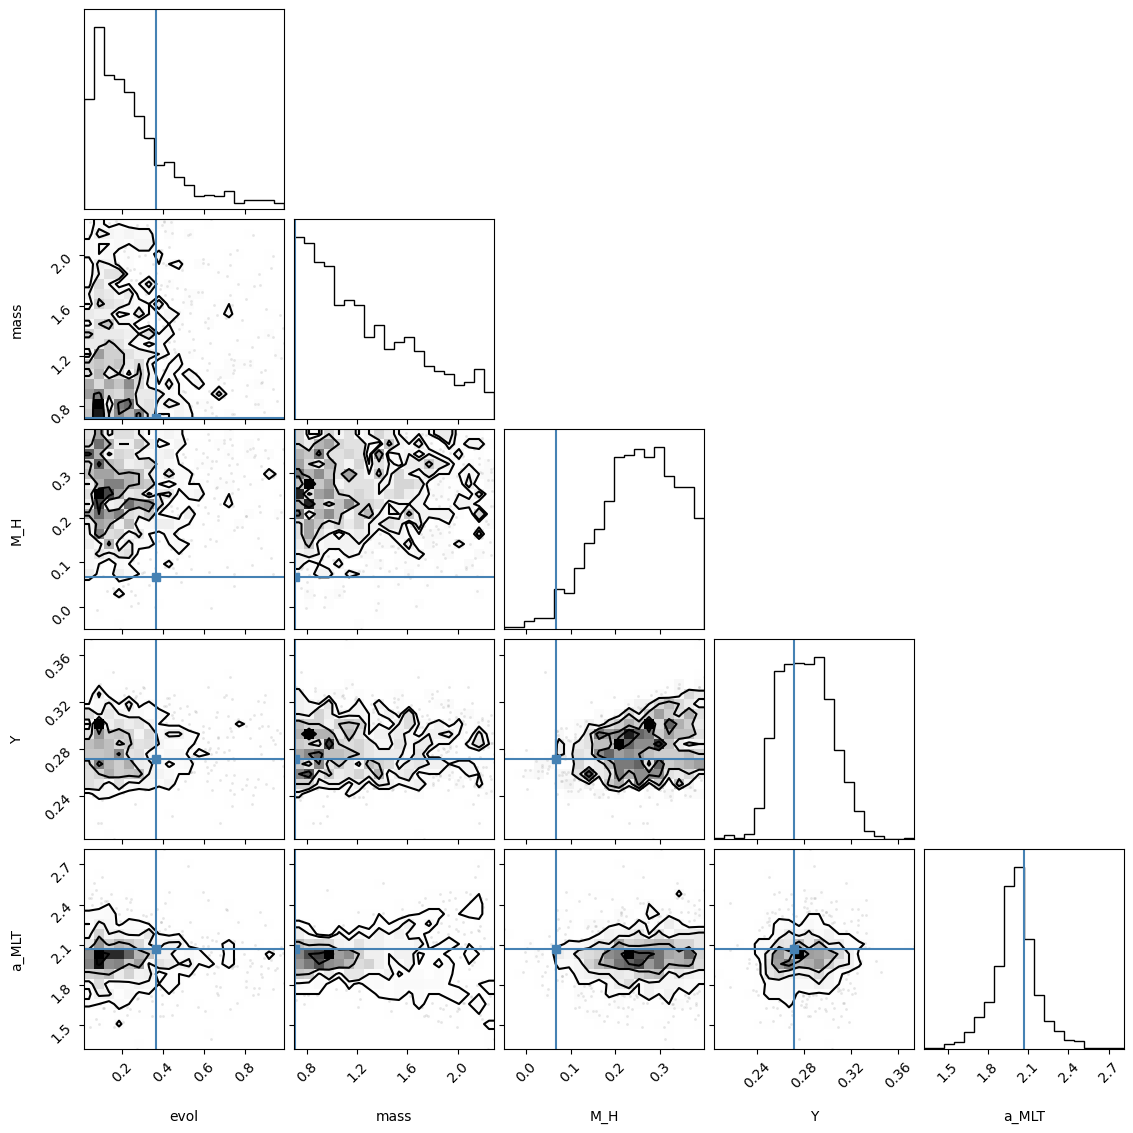

In [73]:
star = 0
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

Let's also look at some determinisitc parameters in the model.

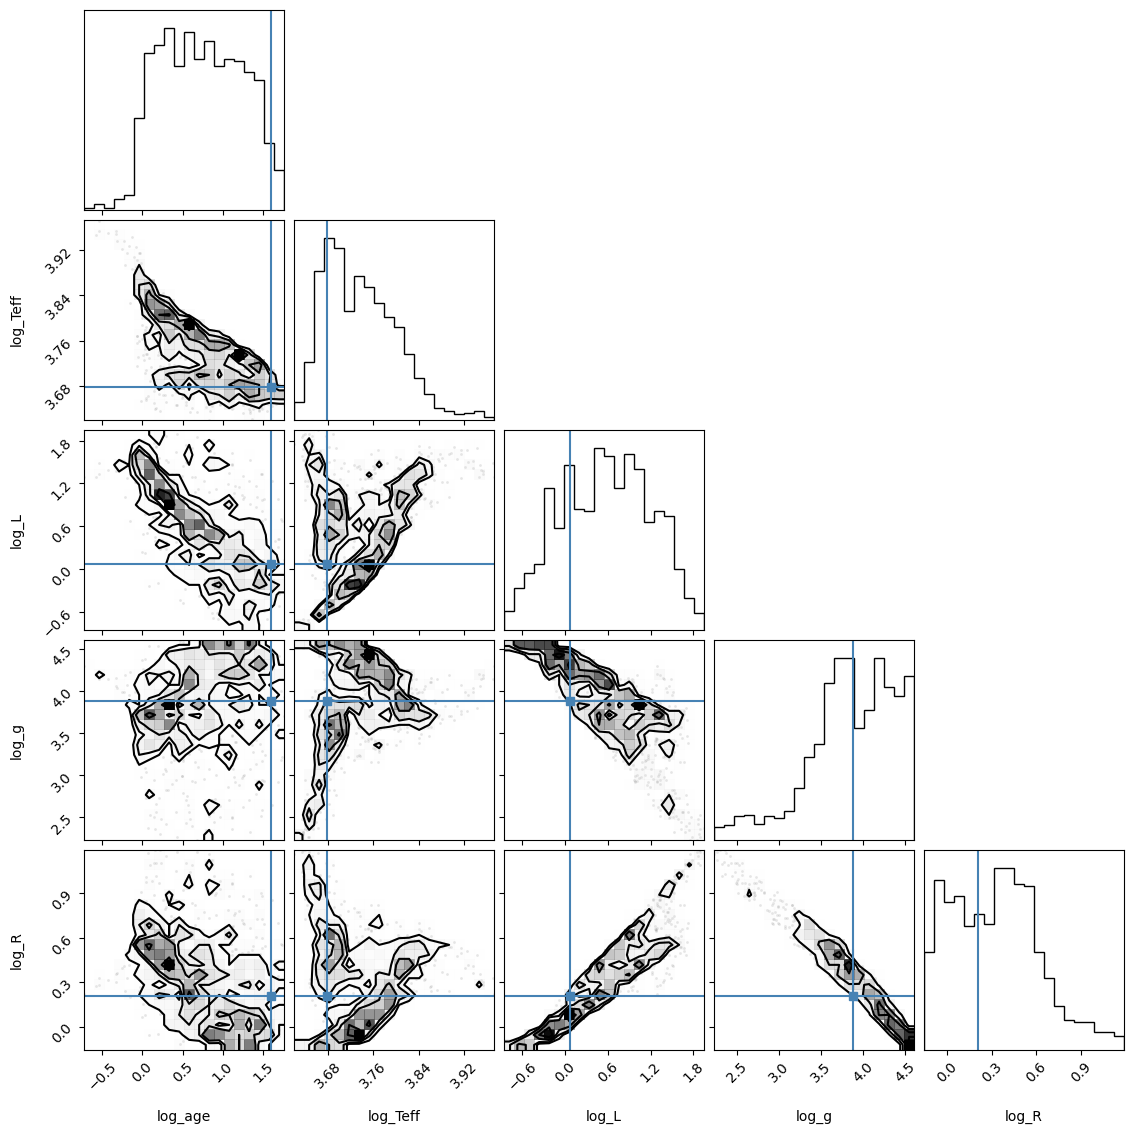

In [74]:
star = 0
var_names = ["log_age", "log_Teff", "log_L", "log_g", "log_R"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

## Observation

Now we synthesize observable parameters for the model.

In [75]:
rng, *keys = random.split(rng, 3)
obs = {
    "Teff": truths["Teff"] + const["Teff"]["scale"] * random.normal(keys[0], shape=truths["Teff"].shape),
    # "log_g": truths["log_g"] + const["log_g"]["scale"] * random.normal(keys[1], shape=truths["log_g"].shape),
    "log_L": truths["log_L"] + const["log_L"]["scale"] * random.normal(keys[1], shape=truths["log_L"].shape),
}
pprint(obs)

{'Teff': Array([ 4787.8193,  5258.019 ,  6703.1978,  5659.2793,  4880.818 ,
        4833.664 ,  5620.0513,  5722.4814,  5779.421 ,  5511.683 ,
        5042.4634,  8960.063 ,  4725.309 ,  8332.602 ,  7099.4834,
        8820.439 ,  6802.349 ,  5062.2446,  5198.072 ,  5394.956 ,
        6058.3027,  5799.2056,  4432.504 ,  9844.648 ,  5153.669 ,
        5068.4805,  5994.9595,  5137.408 ,  5656.3193,  7217.0537,
        5927.5054,  5334.07  ,  4619.8276,  6541.982 ,  5191.529 ,
        7353.8013,  4630.82  ,  4777.6714,  6830.2534,  5530.966 ,
        6073.646 ,  4908.4014,  5130.0015,  7438.044 ,  5981.3887,
        8262.457 ,  5492.7847,  5842.2515,  5785.6157,  8418.365 ,
        5050.174 ,  5079.5776,  6454.724 ,  5091.095 ,  8542.033 ,
       11151.093 ,  5977.05  ,  5624.0483,  5945.6187,  5833.758 ,
        6340.624 ,  7177.518 ,  5897.476 ,  5310.1733,  4763.774 ,
        5593.265 ,  4900.7515,  6499.585 ,  6205.5933,  4979.8623,
        6089.0254,  5617.2485,  4782.5723,  4904.675 

## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [76]:
# good_stars = np.array([i for i in range(num_stars) if i not in bad_stars], dtype=int)


In [77]:
# model.num_stars = len(good_stars)
# model.const["M_H"]["loc"] = const["M_H"]["loc"][good_stars]

In [78]:
# good_obs = {k: v[good_stars] for k, v in obs.items()}

In [81]:
# sampler = NUTS(model, target_accept_prob=0.8, dense_mass=[("dY_dZ", "da_dM", "sigma_Y", "sigma_a")], init_strategy=init_to_median)
sampler = NUTS(model, target_accept_prob=0.8, init_strategy=init_to_median)
mcmc = MCMC(sampler, num_warmup=3000, num_samples=1000, num_chains=2)

Let's run the MCMC and print a summary of results.

In [82]:
rng, key = random.split(rng)
start = time()
mcmc.run(key, obs=obs)
elapsed_time = time() - start
mcmc.print_summary()

/home/alex/miniconda3/envs/celestify-cuda/lib/python3.10/site-packages/jax/_src/linear_util.py:191: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))


Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

**Note:** The `MultiStarModel` takes longer than running `SingleStarModel` sequentially, but includes population-level priors. It's worth looking at other ways to do this faster.

Let's update our `InferenceData`.

In [1]:
data += az.from_numpyro(mcmc, coords=coords, dims=dims)
data

NameError: name 'data' is not defined

With `arviz`, we can create a summary of the data.

In [20]:
param_names = [k for k, v in true_trace.items() if v["type"] == "sample" and k not in hyperparam_names]

In [21]:
summary = az.summary(data, fmt="xarray", var_names=param_names)
summary

<xarray.Dataset>
Dimensions:       (metric: 9, star: 100)
Coordinates:
  * star          (star) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * metric        (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
Data variables:
    log_evol      (metric, star) float64 -0.4878 -1.055 -1.164 ... 1.044 1.006
    log_mass      (metric, star) float64 -0.1087 -0.08867 0.1675 ... 1.016 1.034
    M_H           (metric, star) float64 0.1669 0.07228 0.1252 ... 1.002 1.001
    Y_decentered  (metric, star) float64 -0.09054 0.07501 0.1582 ... 1.045 1.015
    a_decentered  (metric, star) float64 0.01491 -0.009576 ... 1.0 0.9996

In [22]:
summary_nan = summary.where(summary.sel(metric="r_hat") < 1.1).to_array()
summary_nan

<xarray.DataArray (variable: 5, metric: 9, star: 100)>
array([[[-4.87804025e-01, -1.05464971e+00, -1.16391253e+00, ...,
         -7.00177968e-01, -7.21457005e-01, -9.23949420e-01],
        [ 3.62197757e-02,  2.46185571e-01,  1.46069065e-01, ...,
          1.20468624e-01,  1.01756856e-01,  1.18299469e-01],
        [-5.55613101e-01, -1.51483190e+00, -1.37484753e+00, ...,
         -9.05125380e-01, -8.70798349e-01, -1.11516154e+00],
        ...,
        [ 2.41312946e+02,  4.17631288e+02,  2.29132485e+01, ...,
          2.94731535e+02,  4.73685431e+01,  6.08552658e+01],
        [ 2.98142758e+02,  7.40487054e+02,  7.80627790e+01, ...,
          3.14012260e+02,  2.20840101e+02,  2.51231555e+02],
        [ 1.01930906e+00,  1.00885131e+00,  1.07133473e+00, ...,
          1.01443155e+00,  1.04367976e+00,  1.00608005e+00]],

       [[-1.08723931e-01, -8.86734501e-02,             nan, ...,
         -9.33041051e-02,  3.45733255e-01,  1.71706364e-01],
        [ 2.89048851e-02,  3.02552134e-02,             nan, ...,
          2.92354617e-02,  1.43647529e-02,  2.50798222e-02],
        [-1.54857263e-01, -1.53243944e-01,             nan, ...,
         -1.43142194e-01,  3.19754004e-01,  1.30902305e-01],
...
        [ 3.12873000e+02,  3.98602808e+02,  7.82895808e+01, ...,
          3.67182444e+02,  5.28467504e+02,  3.58370526e+02],
        [ 4.67792781e+02,  8.74170943e+02,  1.69397314e+02, ...,
          1.34064820e+02,  7.36662774e+02,  8.55391528e+02],
        [ 1.02786281e+00,  1.02656038e+00,  1.03460780e+00, ...,
          1.02177105e+00,  1.04515328e+00,  1.01514335e+00]],

       [[ 1.49065796e-02, -9.57636442e-03, -9.58237145e-03, ...,
         -5.15213050e-02, -1.03495583e-01,  6.47894219e-02],
        [ 9.70635295e-01,  9.65687990e-01,  9.99712586e-01, ...,
          1.00316679e+00,  1.04657137e+00,  9.76023912e-01],
        [-1.87749243e+00, -1.86957610e+00, -1.86107278e+00, ...,
         -1.91355228e+00, -2.03027701e+00, -1.80826735e+00],
        ...,
        [ 6.23736270e+02,  8.09683336e+02,  9.34424722e+02, ...,
          7.33344631e+02,  8.97930504e+02,  8.73327690e+02],
        [ 1.03889492e+03,  1.15388702e+03,  1.14004548e+03, ...,
          1.04643146e+03,  1.04015894e+03,  8.07037997e+02],
        [ 1.00015013e+00,  1.00101760e+00,  1.00072722e+00, ...,
          1.00186926e+00,  1.00037996e+00,  9.99579508e-01]]])
Coordinates:
  * star      (star) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * metric    (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
  * variable  (variable) object 'log_evol' 'log_mass' ... 'a_decentered'

In [23]:
summary_stacked = summary_nan.stack(x=["variable", "metric", "star"])
null_coords = summary_stacked[summary_stacked.isnull()].coords

In [24]:
bad_stars = set(null_coords["star"].values)

In [25]:
efficiency = summary.sel(metric="ess_bulk") / elapsed_time

In [26]:
efficiency

<xarray.Dataset>
Dimensions:       (star: 100)
Coordinates:
  * star          (star) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
    metric        <U9 'ess_bulk'
Data variables:
    log_evol      (star) float64 0.3309 0.5727 0.03142 ... 0.06496 0.08345
    log_mass      (star) float64 0.2066 0.3653 0.04887 ... 0.2719 0.4674 0.1013
    M_H           (star) float64 1.03 1.064 0.4932 0.8853 ... 1.127 1.181 1.244
    Y_decentered  (star) float64 0.429 0.5466 0.1074 ... 0.5035 0.7247 0.4914
    a_decentered  (star) float64 0.8553 1.11 1.281 1.085 ... 1.006 1.231 1.198

In [27]:
values = []
for value in efficiency.values():
    values.append(np.atleast_1d(value))

eff = np.concatenate(values)

Text(0, 0.5, 'Count')

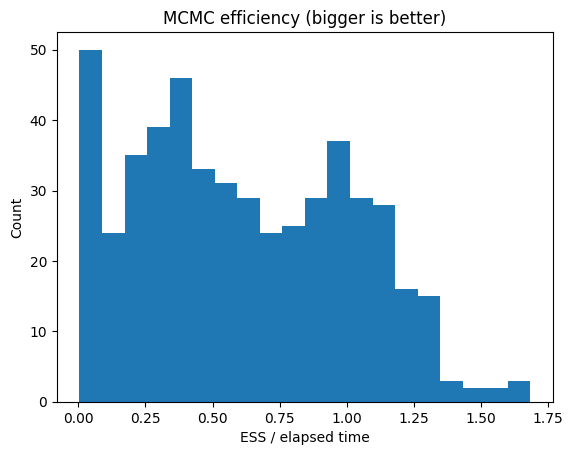

In [28]:
fig, ax = plt.subplots()

ax.hist(eff, bins=20)
ax.set_title("MCMC efficiency (bigger is better)")
ax.set_xlabel("ESS / elapsed time")
ax.set_ylabel("Count")

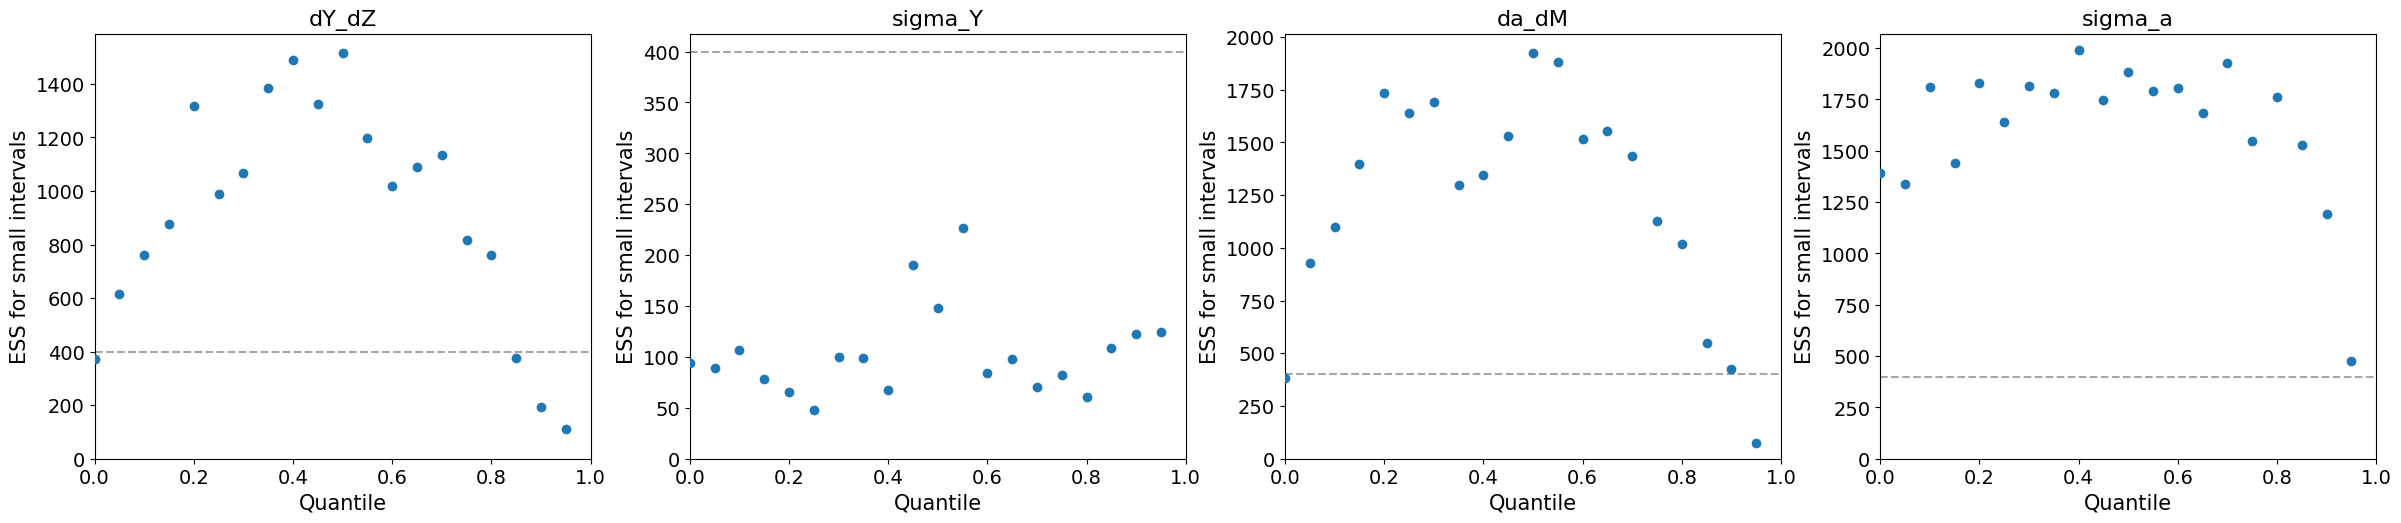

In [29]:
az.plot_ess(data, var_names=hyperparam_names);

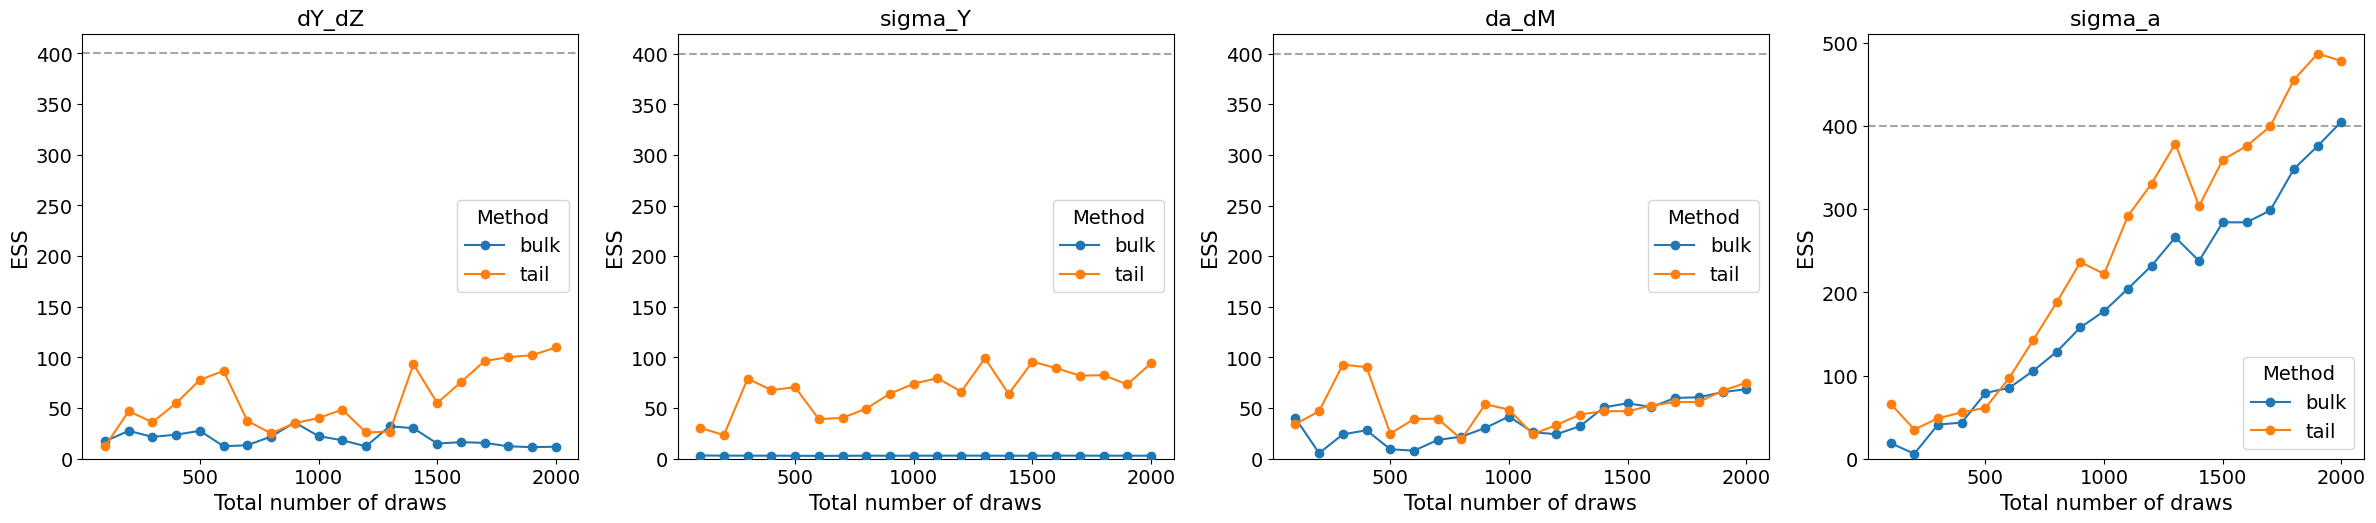

In [30]:
az.plot_ess(data, kind="evolution", var_names=hyperparam_names);

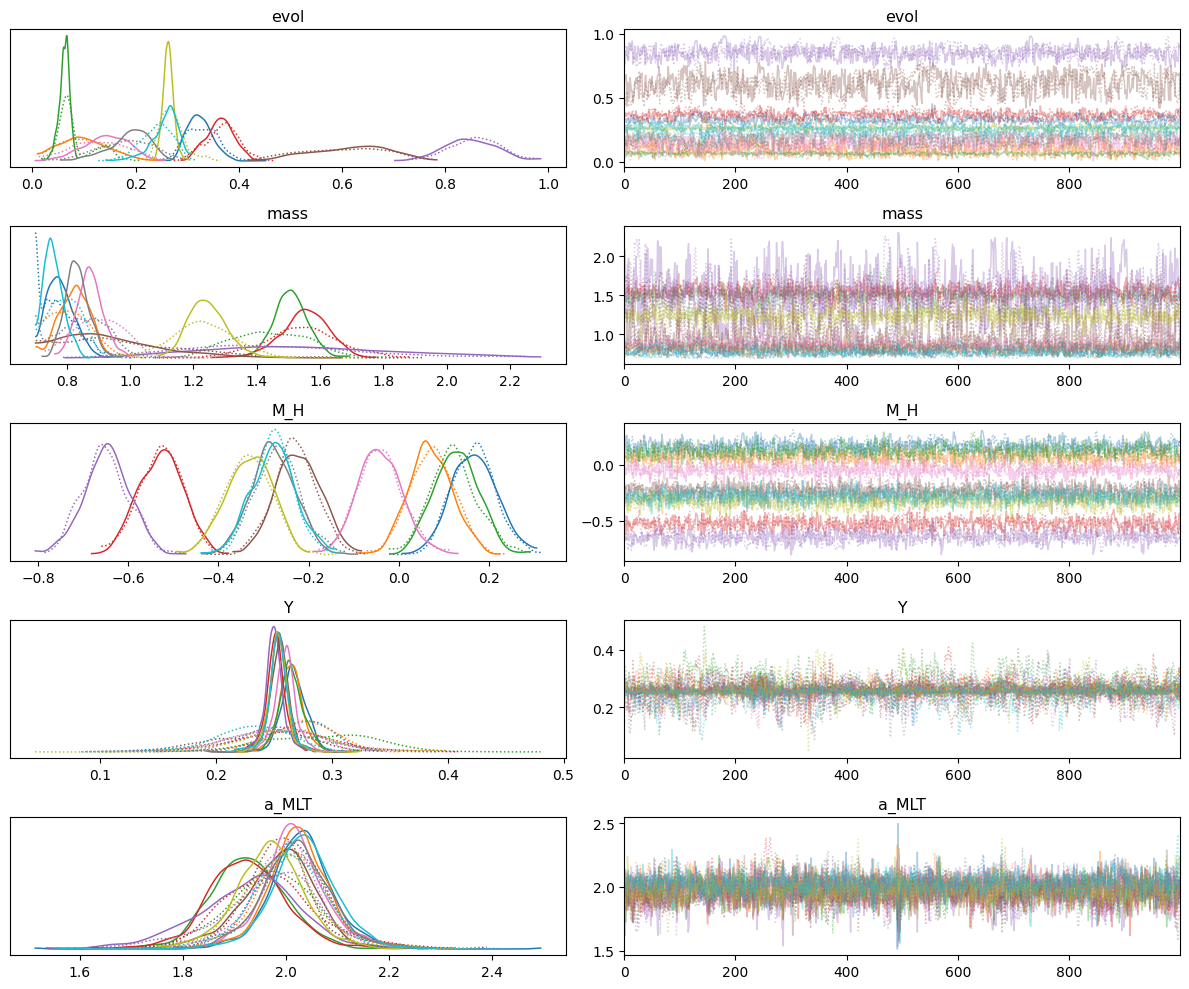

In [31]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
az.plot_trace(data, var_names=var_names, coords=dict(star=range(10)))
# az.plot_trace(data, var_names=var_names, coords=dict(star=good_stars[:10]))
plt.tight_layout()

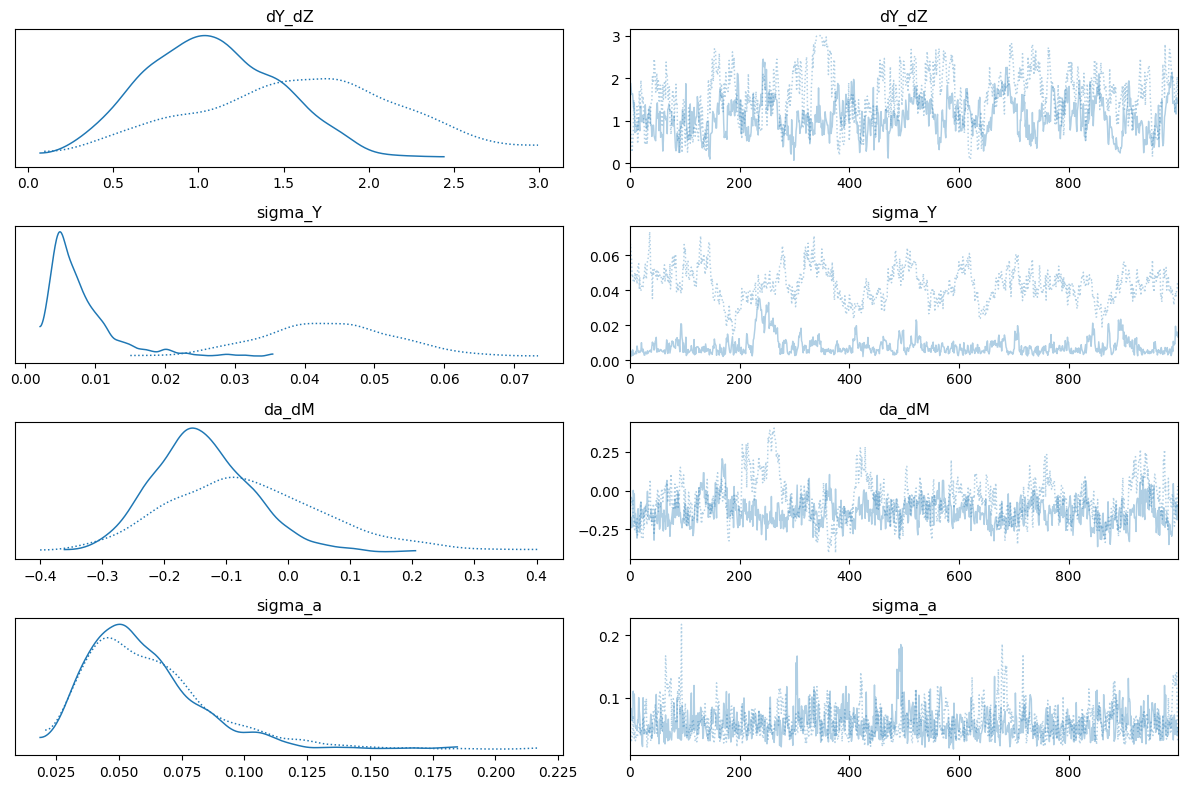

In [32]:
az.plot_trace(data, var_names=hyperparam_names)
plt.tight_layout()

## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

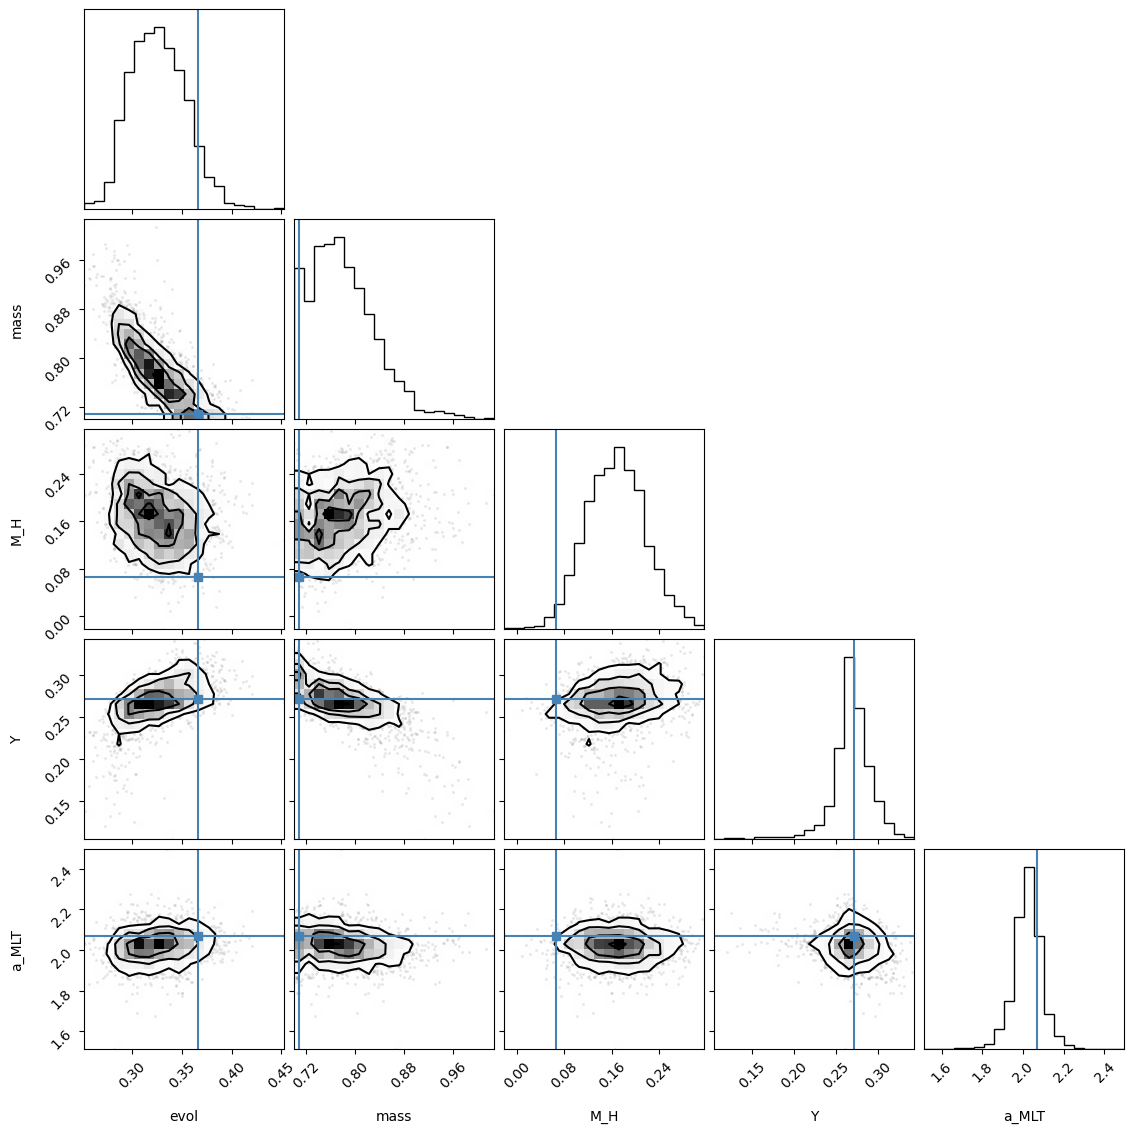

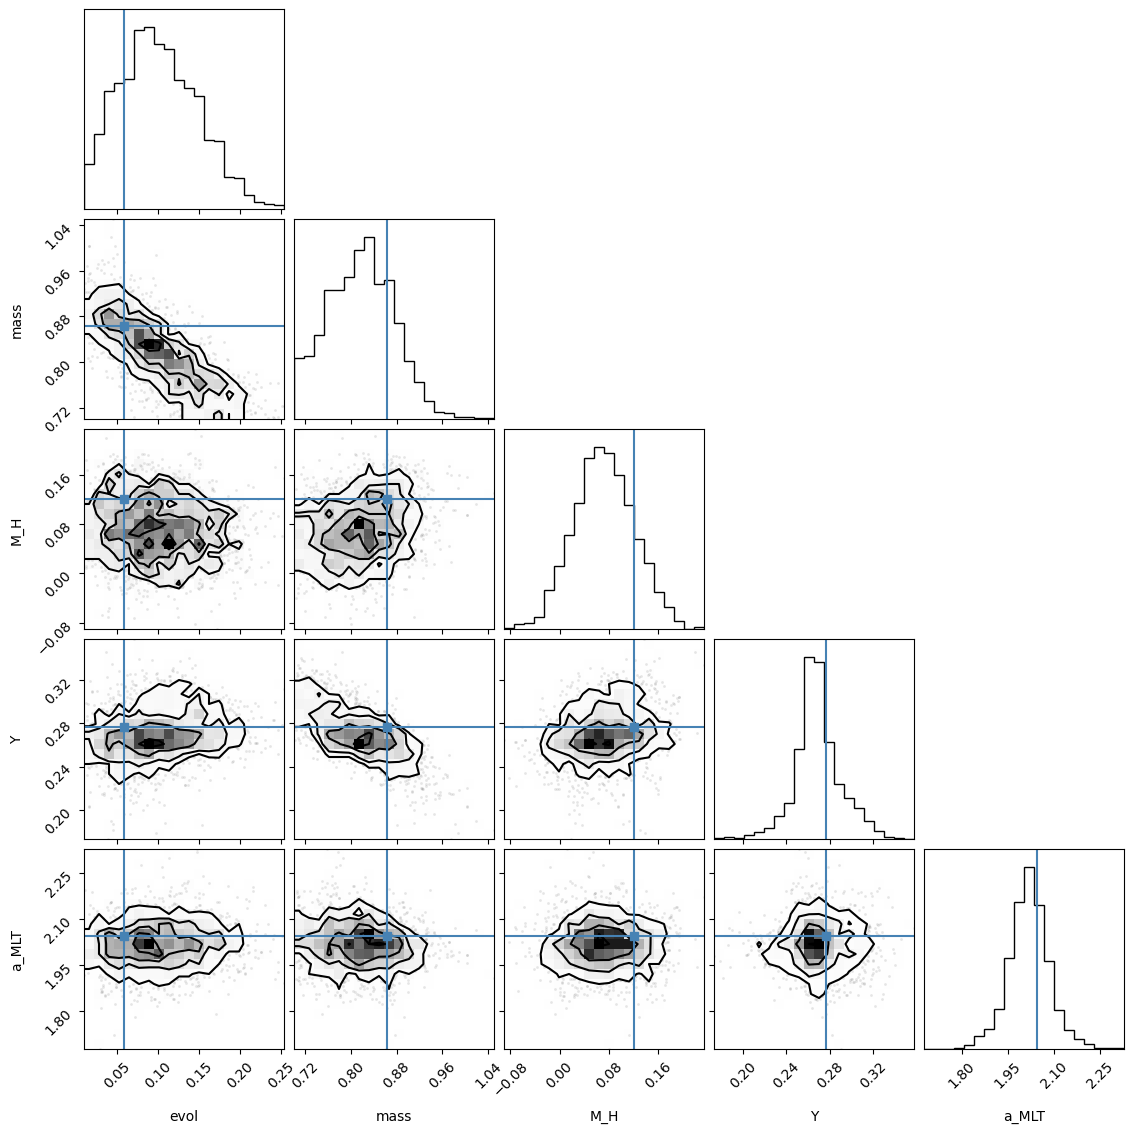

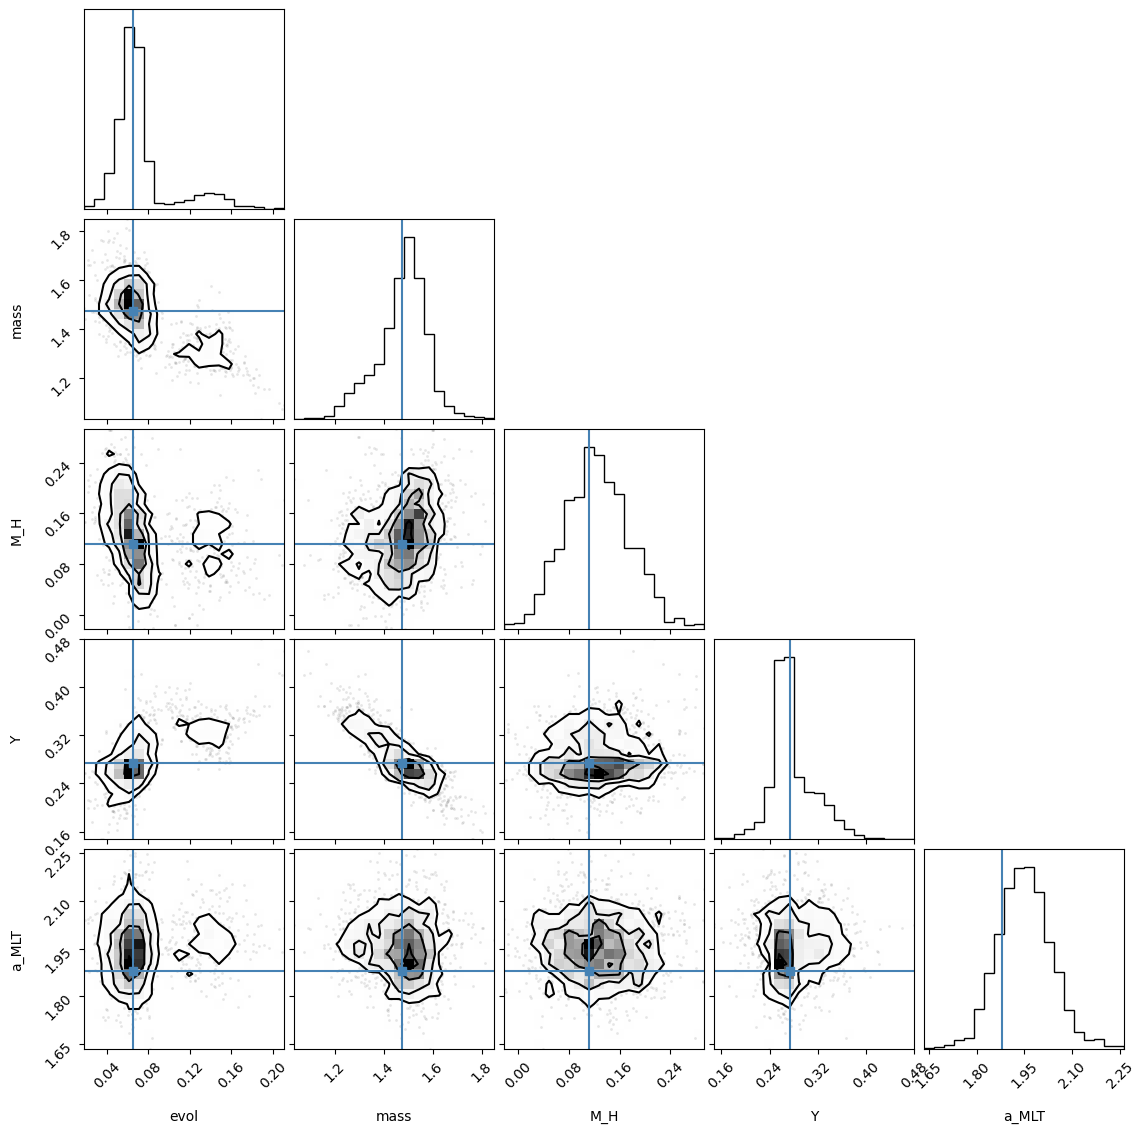

In [33]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

In [34]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
star = 11
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

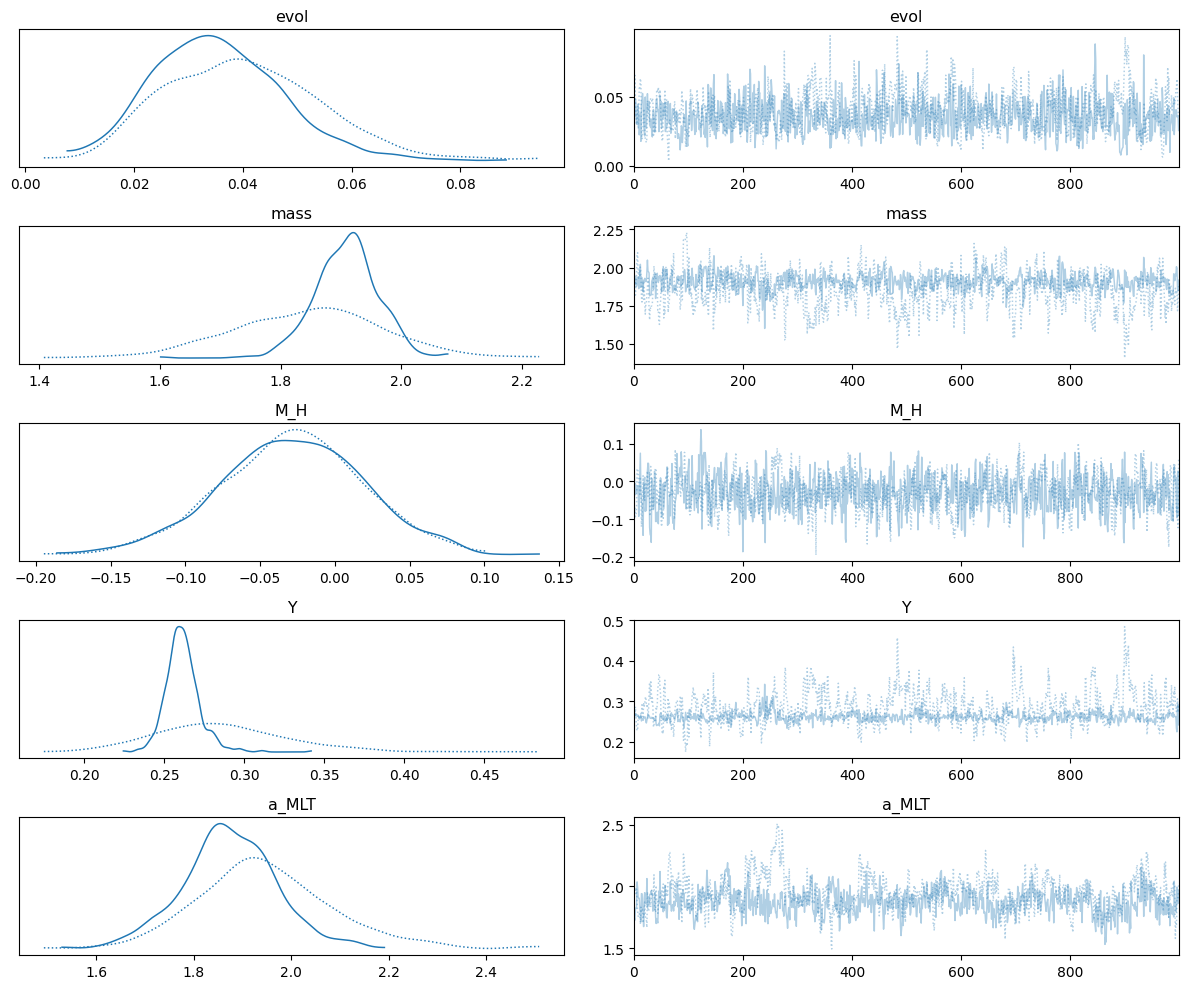

In [35]:
az.plot_trace(data, var_names=var_names, coords=coords_)
plt.tight_layout()

What do we predict for some deterministics?

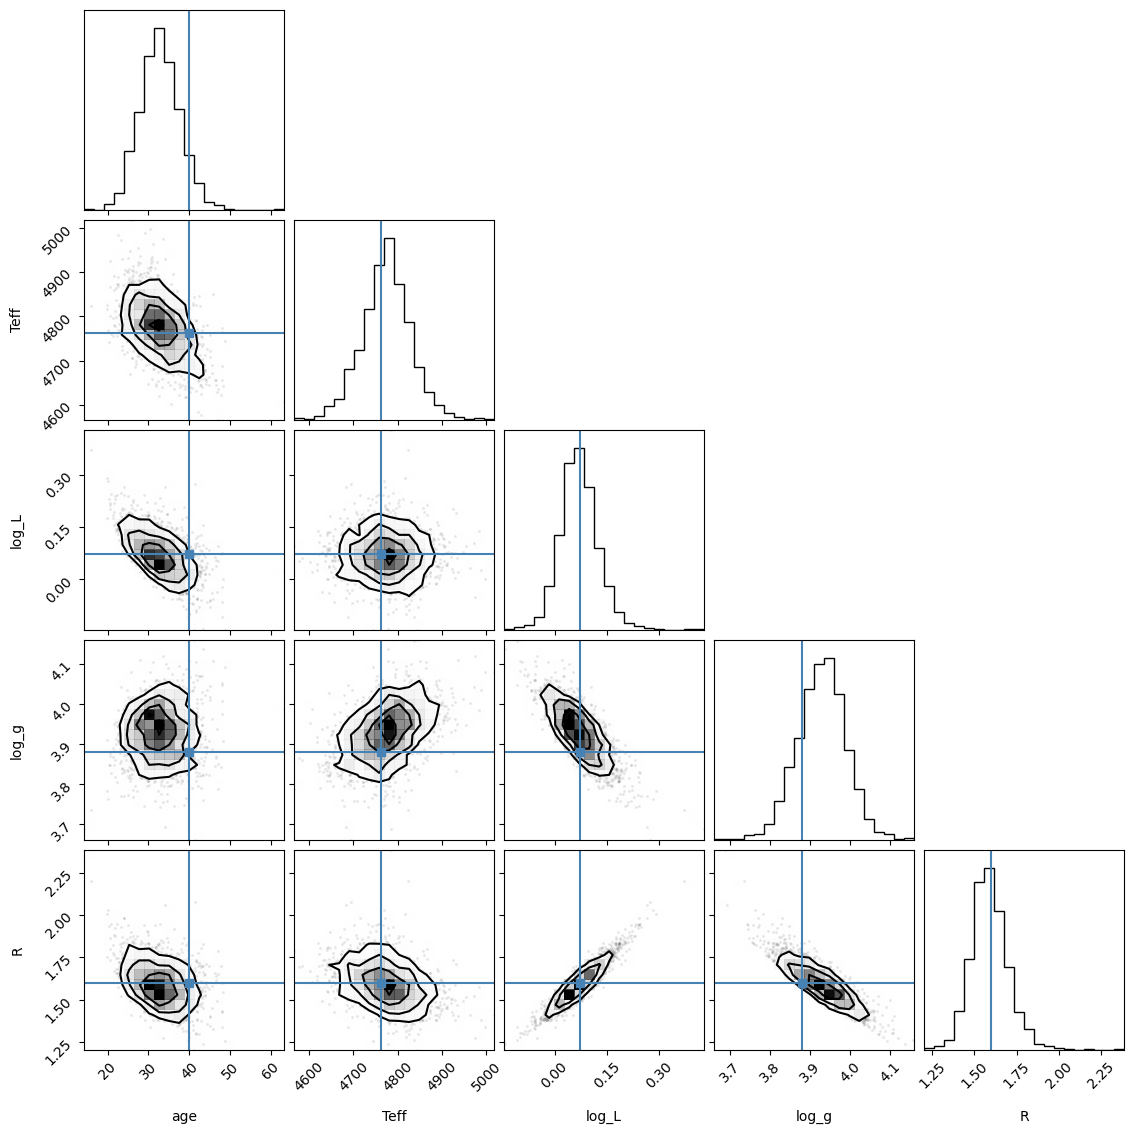

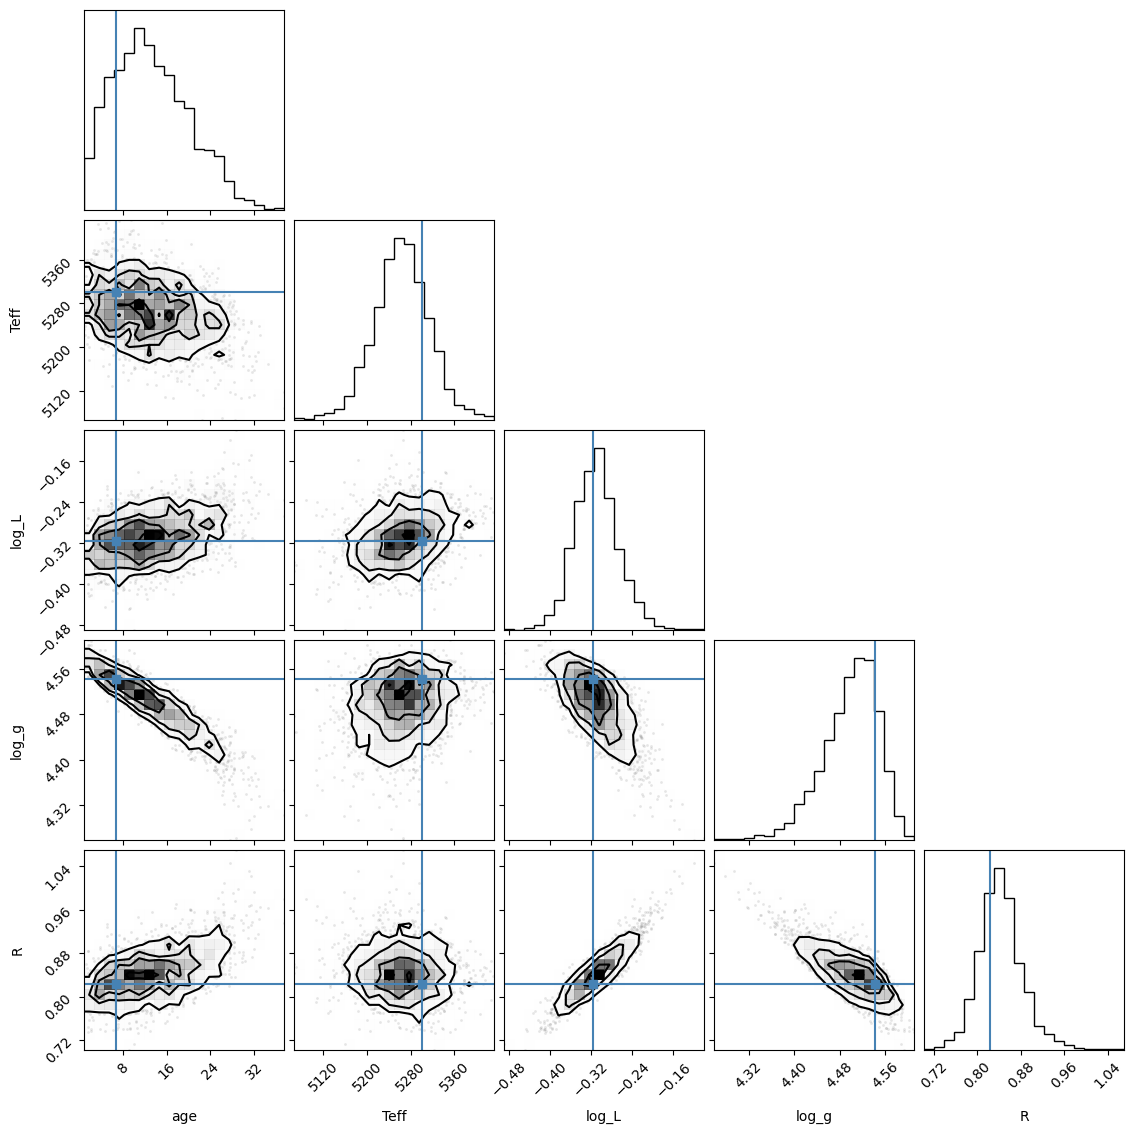

In [37]:
var_names = ["age", "Teff", "log_L", "log_g", "R"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

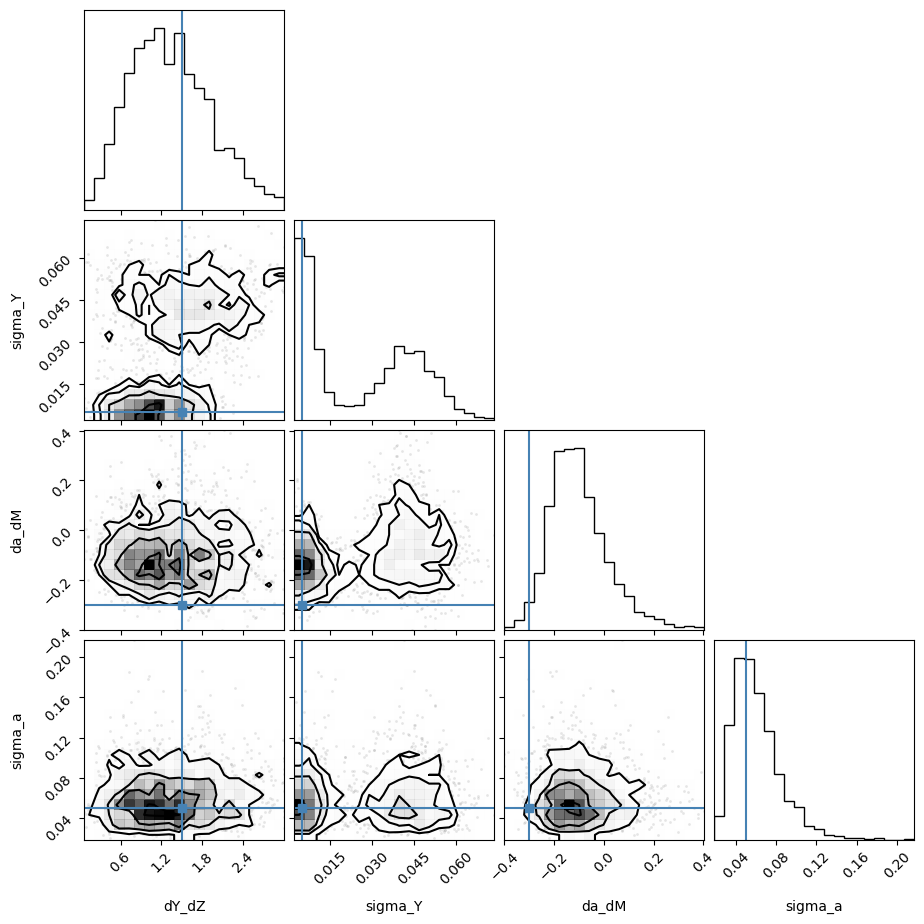

In [38]:
fig = corner(data, group="posterior", var_names=hyperparam_names, truths=truths)

Let's look at the fractional error between each posterior sample and the truth. This gives us an idea of the precision and accuracy of our results. Don't expect anything impressive, we are marginalising over `Y` and `a_MLT` after all.

In [38]:
error = truths - data.posterior
az.summary(error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]     0.009  0.110  -0.207    0.206      0.015    0.011      56.0   
M_H[1]    -0.153  0.096  -0.333    0.025      0.005    0.004     321.0   
M_H[2]     0.052  0.101  -0.145    0.237      0.009    0.007     131.0   
M_H[3]    -0.051  0.065  -0.137    0.065      0.004    0.003     172.0   
M_H[4]     0.033  0.088  -0.142    0.190      0.007    0.005     145.0   
...          ...    ...     ...      ...        ...      ...       ...   
mass[497] -0.022  0.128  -0.212    0.197      0.013    0.009      71.0   
mass[498] -0.291  0.247  -0.748    0.152      0.017    0.012     199.0   
mass[499]  0.001  0.134  -0.279    0.230      0.008    0.006     303.0   
sigma_Y   -0.008  0.007  -0.023    0.002      0.003    0.002       6.0   
sigma_a   -0.015  0.025  -0.059    0.027      0.002    0.002     133.0   

           ess_tail  r_hat  
M_H[0]         91.0   1.02  
M_H[1]        476.0   1.00  
M_H[2]        126.0   1.01  
M_H[3]        179.0   1.01  
M_H[4]        236.0   1.02  
...             ...    ...  
mass[497]      36.0   1.02  
mass[498]     309.0   1.01  
mass[499]     378.0   1.00  
sigma_Y        35.0   1.25  
sigma_a       280.0   1.01  

[9004 rows x 9 columns]

In [39]:
fractional_error = (truths - data.posterior) / truths
az.summary(fractional_error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]    -0.084  1.048  -1.956    1.965      0.144    0.102      56.0   
M_H[1]     0.222  0.138  -0.036    0.483      0.008    0.005     321.0   
M_H[2]    -0.115  0.222  -0.523    0.321      0.020    0.016     131.0   
M_H[3]    -0.195  0.246  -0.524    0.246      0.017    0.012     172.0   
M_H[4]     0.184  0.488  -0.784    1.052      0.040    0.028     145.0   
...          ...    ...     ...      ...        ...      ...       ...   
mass[497] -0.011  0.061  -0.102    0.094      0.006    0.004      71.0   
mass[498] -0.319  0.271  -0.821    0.167      0.019    0.013     199.0   
mass[499]  0.001  0.111  -0.230    0.190      0.006    0.005     303.0   
sigma_Y   -1.530  1.483  -4.595    0.458      0.600    0.446       6.0   
sigma_a   -0.295  0.498  -1.186    0.538      0.044    0.031     133.0   

           ess_tail  r_hat  
M_H[0]         91.0   1.02  
M_H[1]        476.0   1.00  
M_H[2]        126.0   1.01  
M_H[3]        179.0   1.01  
M_H[4]        236.0   1.02  
...             ...    ...  
mass[497]      36.0   1.02  
mass[498]     309.0   1.01  
mass[499]     378.0   1.00  
sigma_Y        35.0   1.25  
sigma_a       280.0   1.01  

[9004 rows x 9 columns]

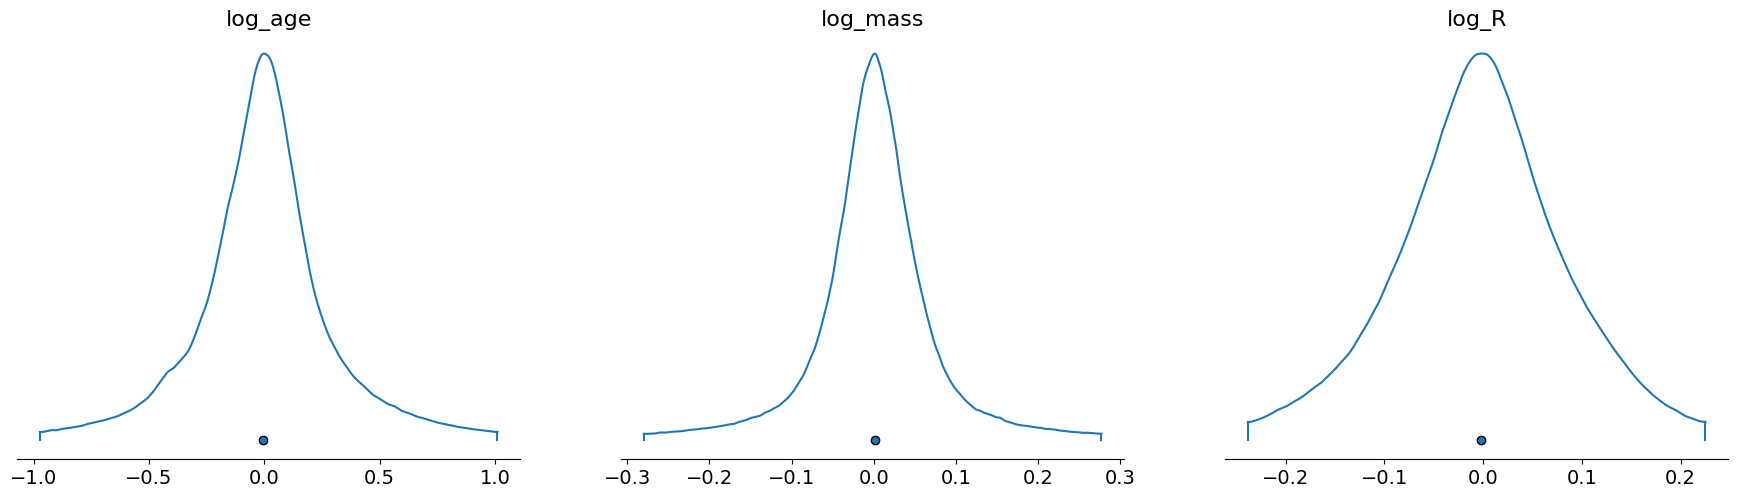

In [40]:
az.plot_density(error, var_names=["log_age", "log_mass", "log_R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

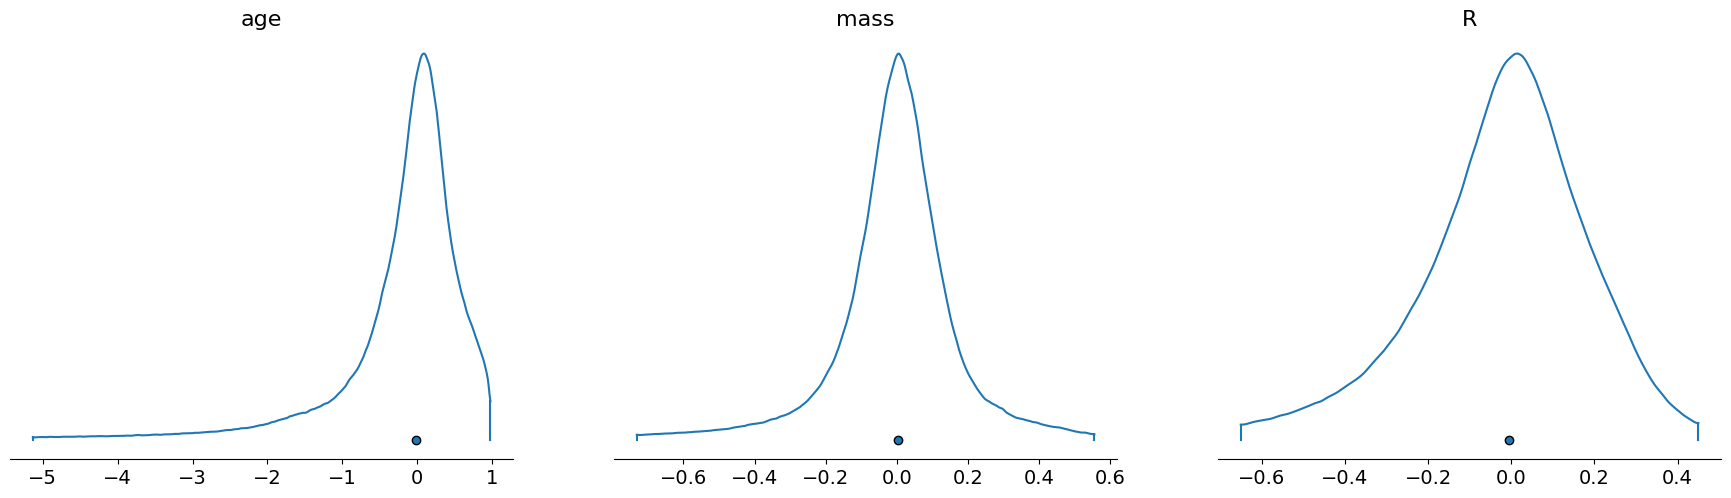

In [41]:
az.plot_density(fractional_error, var_names=["age", "mass", "R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

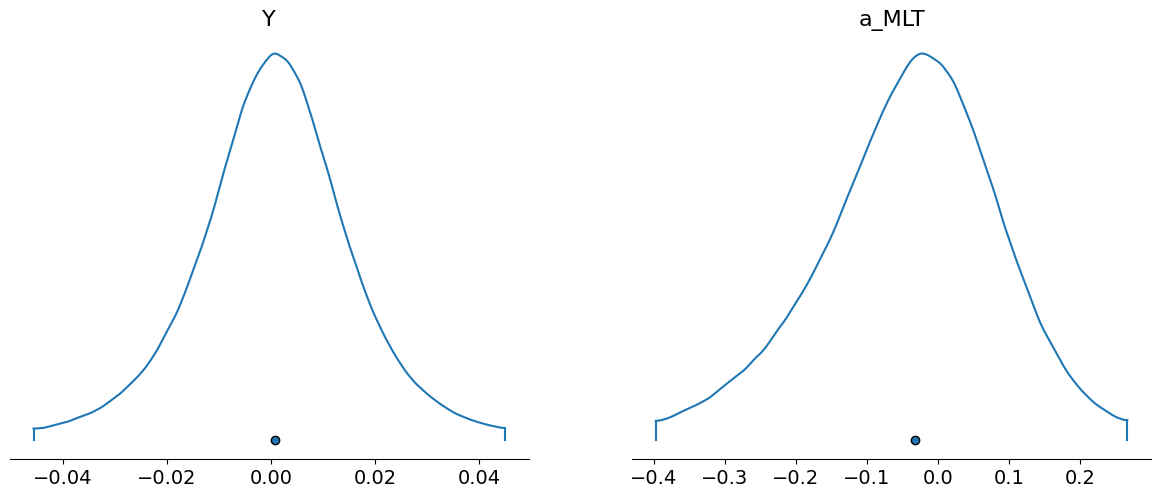

In [42]:
az.plot_density(error, var_names=["Y", "a_MLT"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

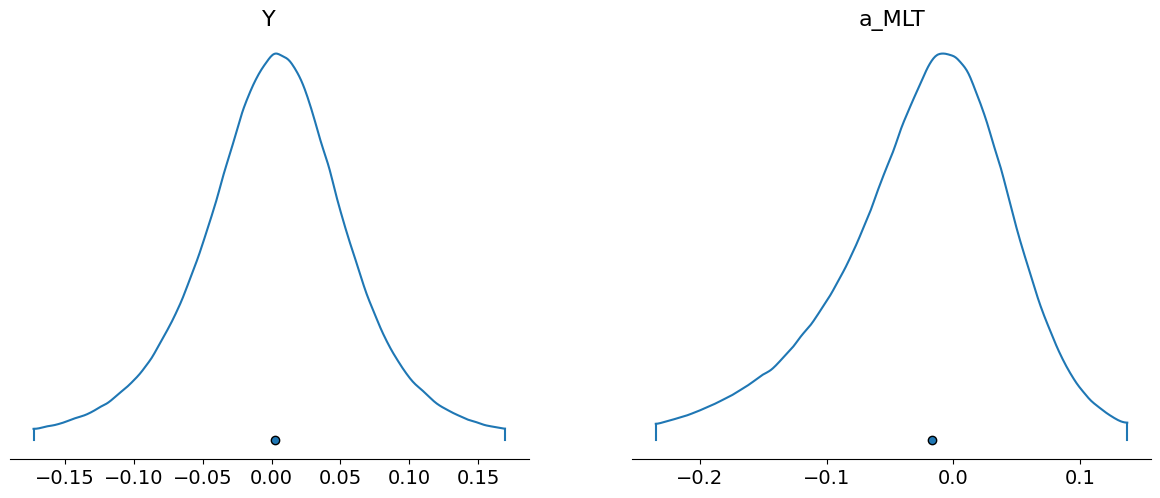

In [43]:
az.plot_density(fractional_error, var_names=["Y", "a_MLT"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);